<a href="https://colab.research.google.com/github/igquinteroch/deep-learning-coursework/blob/main/A1a_DL_TC5033_A01794419.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TC 5033
## Deep Learning
## Fully Connected Deep Neural Networks


#### Activity 1a: Implementing a Multilayer Fully Connected Network using Numpy
#### Non-graded activity (0 points)

- Objective

  The primary objective of this activity is to deepen your understanding of Fully Connected Networks by implementing a multilayer network using only Numpy. You  are  given  the follosing starter code that solves the MNIST dataset problem. Your task is to read, understand, and then apply this knowledge to solve classification problems on other datasets such as the Kaggle ASL dataset (Starter code will be provided separately for that activity).

- Instructions

    Read and Understand the following Code: The provided starter code outlines the architecture of a Fully Connected Network designed to classify MNIST images. Go through the code to understand how each function and class is used to implement the network.

    Understand the Math: Make sure you understand the math operations implemented in the code, especially during the forward and backward passes. This will involve matrix multiplications, activation functions, loss computations, and backpropagation.
    
- Experiment
    You are encouraged to play with the code, change any hyperparameters and train the model, you should be able to achieve over 95% accuracy on the test set without problems.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

import os
os.chdir("/content/drive/MyDrive/TC5033.10")

Mounted at /content/drive


### Import Images

In [ ]:
from get_images import get_images

In [ ]:
# MNIST path
mnist_path = './mnist_raw/'
x_train_num, y_train_num, x_test_num, y_test_num = get_images(mnist_path)


x_train = x_train_num[:50000].reshape(50000, -1).astype(float) # First 50k data and reshape it
y_train = y_train_num[:50000].reshape(50000, 1)

x_val = x_train_num[50000:].reshape(10000, -1).astype(float)
y_val = y_train_num[50000:].reshape(10000, 1)

x_test = x_test_num.copy().reshape(10000, -1).astype(float)
y_test = y_test_num.copy().reshape(10000, 1)

In [ ]:
x_train.mean(), x_train.std(), x_train.min()

(33.39512885204082, 78.6661972212754, 0.0)

In [ ]:
def normalise(x_mean, x_std, x_data):
    return (x_data - x_mean) / x_std

It's necessary to normalize the validation and test data with the statistical data from training.

In [ ]:
x_mean = x_train.mean()
x_std = x_train.std()

x_train = normalise(x_mean, x_std, x_train)
x_val = normalise(x_mean, x_std, x_val)
x_test = normalise(x_mean, x_std, x_test)

In [ ]:
x_train.mean(), x_train.std()

(-9.646705203355238e-18, 0.9999999999999997)

### Plot samples

In [ ]:
def plot_number(image):
    plt.figure(figsize=(5,5))
    plt.imshow(image.squeeze(), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.show()

La imagen muestreada representa un: 4


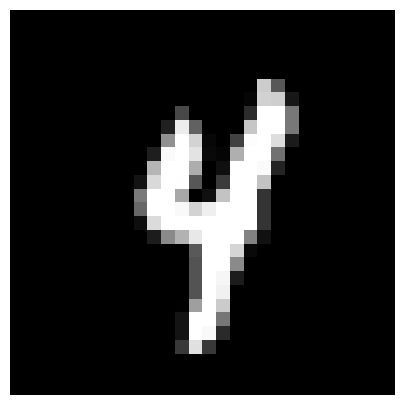

In [ ]:
rnd_idx = np.random.randint(len(y_test))
print(f'The image represents a/an: {y_test[rnd_idx, 0]}')
plot_number(x_test_num[rnd_idx])

### Equations


$$z^1 = W^1 X + b^1$$

$$a^1 = ReLU(z^1) $$

$$z^2 = W^2 a^1 + b^2$$

$$\hat{y} = \frac{e^{z^{2_k}}}{\sum_j{e^{z_j}}}$$


$$ \mathcal{L}(\hat{y}^{i}, y^{i}) =  - y^{i}  \ln(\hat{y}^{i}) = -\ln(\hat{y}^i)$$


$$ \mathcal{J}(w, b) =  \frac{1}{num\_samples} \sum_{i=1}^{num\_samples}-\ln(\hat{y}^{i})$$

### Helper functions

#### Creat Mini batches

In [ ]:
def create_minibatches(mb_size, x, y, shuffle = True):
    '''
    x shape: (#muestras, 784)
    y shape: (#muestras, 1)

    elemento 0 de x & y sean iguales
    '''
    assert x.shape[0] == y.shape[0], 'Error en cantidad de muestras'
    total_data = x.shape[0]
    if shuffle:
        idxs = np.arange(total_data)
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]
    return ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size))

## Nuestra clase Linear, ReLU y Sequential

In [ ]:
# generate attributes to the parameters using the below class
# objects to inherit from np.darray class

"""
(np.ndarray): This indicates that the new class ´np_tensor´ inherits from the ´np.ndarray´ class.
´np.ndarray´ is the core class in the NumPy library representing multi-dimensional arrays.
By inheriting from ´np.darray´, ´np_tensor´ gets all the functionality of NumPy arrays.
"""

class np_tensor(np.ndarray): pass

In [ ]:
a = np.array([0, 0])
b = a.view(np_tensor)

In [ ]:
type(a)

numpy.ndarray

In [ ]:
type(b)

__main__.np_tensor

In [ ]:
a == b

np_tensor([ True,  True])

In [ ]:
a is b

False

###  Clase Linear

In [ ]:
class Linear():
    def __init__(self, input_size, output_size):
        '''
        Init parameters utilizando Kaiming He
        '''
        self.W = (np.random.randn(output_size, input_size) / np.sqrt(input_size/2)).view(np_tensor)
        self.b = (np.zeros((output_size, 1))).view(np_tensor)

    # __call__: se llama de forma automática cuando mandamos a llamar el nombre de la instancia de la clase y le pasamos los parámetros
    def __call__(self, X): # esta el forward de la clase lineal
        Z = self.W @ X + self.b # @ = producto
        return Z

    def backward(self, X, Z): # X = entrada (salida de la capa previa), Z = salida
        X.grad = self.W.T @ Z.grad
        self.W.grad = Z.grad @ X.T
        self.b.grad = np.sum(Z.grad, axis = 1, keepdims=True)


### Clase ReLU

In [ ]:
class ReLU():
    def __call__(self, Z): # Z: entrada
        return np.maximum(0, Z)
    def backward(self, Z, A): # A: salida
        Z.grad = A.grad.copy()
        Z.grad[Z <= 0] = 0

### Clase Sequential

In [ ]:
class Sequential_layers():
    def __init__(self, layers):
        '''
        layers - lista que contiene objetos de tipo Linear, ReLU
        '''
        self.layers = layers
        self.x = None
        self.outputs = {}
    def __call__(self, X):
        self.x = X
        self.outputs['l0'] = self.x
        for i, layer in enumerate(self.layers, 1):
            self.x = layer(self.x)
            self.outputs['l'+str(i)]=self.x
        return self.x
    def backward(self):
        for i in reversed(range(len(self.layers))):
            self.layers[i].backward(self.outputs['l'+str(i)], self.outputs['l'+str(i+1)])
    def update(self, learning_rate = 1e-3):
        for layer in self.layers:
            if isinstance(layer, ReLU): continue
            layer.W = layer.W - learning_rate * layer.W.grad
            layer.b = layer.b - learning_rate * layer.b.grad
    def predict(self, X):
        return np.argmax(self.__call__(X))

### Cost Function

In [ ]:
def softmaxXEntropy(x, y):
    batch_size = x.shape[1]
    exp_scores = np.exp(x)
    probs = exp_scores / exp_scores.sum(axis = 0)
    preds = probs.copy()

    # Costo
    y_hat = probs[y.squeeze(), np.arange(batch_size)]
    cost = np.sum(-np.log(y_hat)) / batch_size

    # Calcular gradientes
    probs[y.squeeze(), np.arange(batch_size)] -= 1 #dl/dx
    x.grad = probs.copy()

    return preds, cost

### Loop de entrenamiento

In [ ]:
def train(model, epochs, mb_size=128, learning_rate = 1e-3):
    for epoch in range(epochs):
        for i, (x, y) in enumerate(create_minibatches(mb_size, x_train, y_train)):
            scores = model(x.T.view(np_tensor))
            _, cost = softmaxXEntropy(scores, y)
            model.backward()
            model.update(learning_rate)
        print(f'costo: {cost}, accuracy: {accuracy(x_val, y_val, mb_size)}')

In [ ]:
def accuracy(x, y, mb_size):
    correct = 0
    total = 0
    for i, (x, y) in enumerate(create_minibatches(mb_size, x, y)):
        pred = model(x.T.view(np_tensor))
        correct += np.sum(np.argmax(pred, axis=0) == y.squeeze())
        total += pred.shape[1]
    return correct/total

In [ ]:
model = Sequential_layers([Linear(784, 200), ReLU(), Linear(200, 200), ReLU(), Linear(200, 10)])
mb_size = 512
learning_rate = 1e-4
epochs = 20

In [ ]:
train(model, epochs, mb_size, learning_rate)

costo: 0.2748565749562539, accuracy: 0.9153
costo: 0.266138750708867, accuracy: 0.9342
costo: 0.22091629310916827, accuracy: 0.9448
costo: 0.15761188334954052, accuracy: 0.9486
costo: 0.17605476048437374, accuracy: 0.9544
costo: 0.15323802445100115, accuracy: 0.9564
costo: 0.12290143216331877, accuracy: 0.9577
costo: 0.09070822762206461, accuracy: 0.961
costo: 0.08887594529312166, accuracy: 0.9634
costo: 0.07698768466478165, accuracy: 0.9642
costo: 0.09124362316080237, accuracy: 0.9646
costo: 0.09478983337509136, accuracy: 0.9654
costo: 0.08579638391071806, accuracy: 0.9666
costo: 0.06066818606518615, accuracy: 0.9692
costo: 0.04989668068183447, accuracy: 0.9686
costo: 0.0761204673348807, accuracy: 0.9694
costo: 0.036981191453869654, accuracy: 0.9699
costo: 0.05047404508607087, accuracy: 0.9721
costo: 0.05182238497662786, accuracy: 0.9703
costo: 0.07575177384034504, accuracy: 0.9719


In [ ]:
print(accuracy(x_test, y_test, mb_size))

0.9719


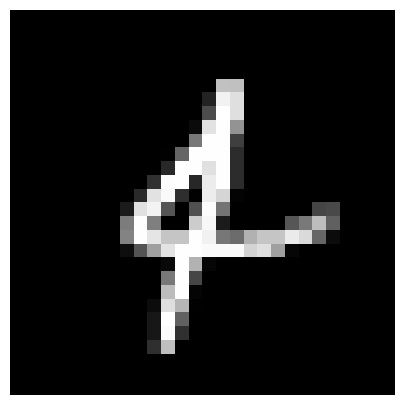

el valor predicho es: 4, el valor real es:4


In [ ]:
idx = np.random.randint(len(y_test))
plot_number(x_test_num[idx])
pred = model.predict(x_test[idx].reshape(-1, 1))
print(f'The predicted value is: {pred} | The real value is:{y_test[idx][0]}')